In [1]:
!nvidia-smi

Thu Jul 29 12:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    N/A /  N/A |    133MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

X = torch.normal(0,1,(3,3))

print(X.shape)

print(torch.rand(X.shape))
print(X)

print(torch.zeros_like(X).shape)
print(torch.zeros(X.shape).shape)

torch.Size([3, 3])
tensor([[0.6723, 0.1265, 0.8840],
        [0.7784, 0.8307, 0.1882],
        [0.9709, 0.3131, 0.2218]])
tensor([[ 1.5512, -0.9820,  0.2297],
        [ 1.2698, -0.1522, -0.7302],
        [ 1.1229,  0.3831, -0.4113]])
torch.Size([3, 3])
torch.Size([3, 3])


In [3]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    
    if dropout == 1:
        # drop everything
        return torch.zeros_like(X)
    
    if dropout == 0:
        # return everything
        return X
    
    mask = (torch.rand(X.shape) > dropout).float()
    
#     print(mask)
    
    return mask * X /(1.0 - dropout)

In [4]:
dropout_layer(X, 0.6)

tensor([[ 0.0000, -0.0000,  0.5742],
        [ 0.0000, -0.3804, -1.8255],
        [ 2.8072,  0.0000, -0.0000]])

In [5]:
dropout_layer(X, 0)

tensor([[ 1.5512, -0.9820,  0.2297],
        [ 1.2698, -0.1522, -0.7302],
        [ 1.1229,  0.3831, -0.4113]])

In [6]:
dropout_layer(X,1)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

### Working with fashion mnist

In [7]:
num_inputs, num_outputs , num_hidden1, num_hidden2 = 784, 10, 256, 256

In [8]:
# defining the model probability at each neural layer

dropout1 = 0.2
dropout2 = 0.5

from torch import nn

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2,is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
        self.drop = dropout_layer
    
    def forward(self, X):
        out = self.relu(self.lin1(X.reshape(-1,num_inputs)))
        
        if self.training:
            out = self.drop(out, dropout1)
            
        out = self.relu(self.lin2(out))
        
        if self.training:
            out = self.drop(out, dropout2)
        out = self.lin3(out)
        
        return out
        
        

In [9]:
net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

In [10]:
X = torch.normal(0,1, (1,784))

In [11]:
net(X).detach()

tensor([[-0.1538, -0.1898, -0.0417, -0.2796,  0.0231, -0.1481, -0.1532, -0.1821,
         -0.0222,  0.2165]])

In [12]:
import torchvision

my_transforms = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root="../data", train=True, download=False, transform=my_transforms)

test_dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, download=False, transform=my_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=256)


In [13]:
def get_label_from_tensor(y):
    text_labels = [
't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
'sneaker', 'bag', 'ankle boot']
    
    return text_labels[int(y)]

sneaker


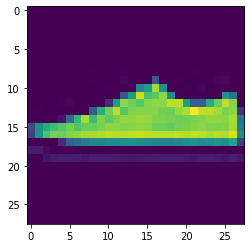

In [14]:
import matplotlib.pyplot as plt

for X,y in train_dataloader:
#     print(X[0].permute(1,2,0).shape)
    plt.imshow(X[0].permute(1,2,0))
    print(get_label_from_tensor(y[0]))
    break

In [15]:
net

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

for epoch 0 train loss : 0.0014056938234716654 test loss : 0.0011823177337646484
for epoch 1 train loss : 0.0018498601857572794 test loss : 0.0023419430945068598
for epoch 2 train loss : 0.0011383382370695472 test loss : 0.0014553054934367537
for epoch 3 train loss : 0.0008820925140753388 test loss : 0.0016587723512202501
for epoch 4 train loss : 0.001385954674333334 test loss : 0.001345330267213285
for epoch 5 train loss : 0.0010746518382802606 test loss : 0.0019814055413007736
for epoch 6 train loss : 0.0014716950245201588 test loss : 0.001329503022134304
for epoch 7 train loss : 0.0011237160069867969 test loss : 0.0015101807657629251
for epoch 8 train loss : 0.0013059667544439435 test loss : 0.0011964797740802169
for epoch 9 train loss : 0.0011094160145148635 test loss : 0.0018120936583727598


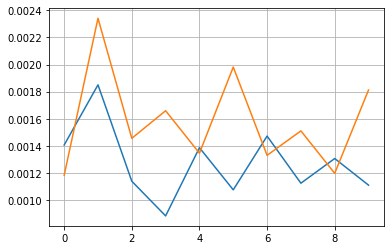

Wall time: 1min 2s


In [19]:
%%time
num_epochs, lr, batch_size = 10, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

def evaluate_loss(net, train_iter, loss):
    
    with torch.no_grad():
        current_loss =0
        current_number = 0
        
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
            if current_number >100:
                break
    
    return current_loss/ current_number

train_loss_array = []
test_loss_array = []

for epoch in range(num_epochs):
    
    for X, y in train_dataloader:
        y_hat = net(X)
        l =  loss(y_hat, y)
    
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    current_train_loss = evaluate_loss(net, train_dataloader, loss)
    current_test_loss = evaluate_loss(net, test_dataloader, loss)
    
    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()
    
    


tensor([[-4.3874, -1.2054, -3.7214, -3.8218, -4.3909,  3.6656, -5.0977, 11.6990,
          0.1095,  8.2049]])
tensor(7)
predicted:  sneaker
base_truth: sneaker


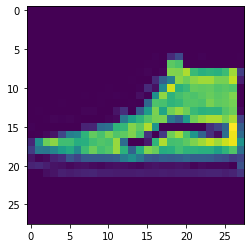

In [21]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():
    print(net(X[0]))

    print(torch.argmax(net(X[0])))

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0]))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

### Concise implementation

In [53]:
def evaluate_loss(net, train_iter, loss):
    net.eval()
    with torch.no_grad():
        current_loss =0
        current_number = 0
        
        for X , y in train_iter:
            current_loss += loss(net(X), y)
            current_number += len(y)
            if current_number > 100:
                break
    
    return current_loss/ current_number


In [42]:
net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                     nn.Linear(num_hidden2, num_outputs))

def init_params(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
#         m.weight_decay=0.3

net_concise.apply(init_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

predicted (before training):  t-shirt
base_truth: sneaker


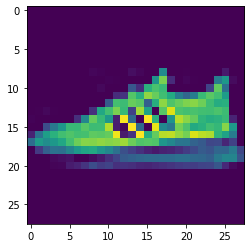

In [43]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted (before training): ", get_label_from_tensor(torch.argmax(net_concise(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

for epoch 0 train loss : 0.08269195258617401 test loss : 0.09472246468067169
for epoch 1 train loss : 0.0847264751791954 test loss : 0.09713464230298996
for epoch 2 train loss : 0.08623427152633667 test loss : 0.09898810088634491
for epoch 3 train loss : 0.08825508505105972 test loss : 0.10050260275602341
for epoch 4 train loss : 0.08988074213266373 test loss : 0.10171326249837875
for epoch 5 train loss : 0.09095261991024017 test loss : 0.10330260545015335
for epoch 6 train loss : 0.09217958152294159 test loss : 0.1048288345336914
for epoch 7 train loss : 0.09386824071407318 test loss : 0.10640580952167511
for epoch 8 train loss : 0.09521199762821198 test loss : 0.10811327397823334
for epoch 9 train loss : 0.09619848430156708 test loss : 0.10955805331468582


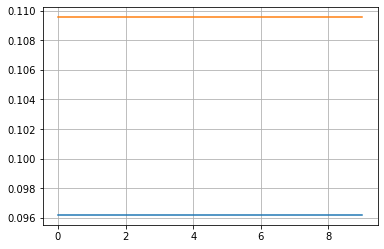

Wall time: 55.7 s


In [44]:
%%time

train_loss_array = []
test_loss_array = []

num_epochs, lr, batch_size = 10, 0.5, 256

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_concise.parameters(), lr=lr)


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        y_hat = net_concise(X)
        l =  loss(y_hat, y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    current_train_loss += evaluate_loss(net_concise, train_dataloader, loss)
    current_test_loss += evaluate_loss(net_concise, test_dataloader, loss)

    train_loss_array.append(current_train_loss)
    test_loss_array.append(current_test_loss)
    
    print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")
    
plt.plot(range(num_epochs), train_loss_array)
plt.plot(range(num_epochs), test_loss_array)
plt.grid(True)
plt.show()


predicted:  ankle boot
base_truth: ankle boot


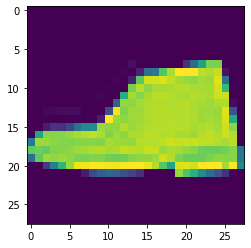

In [45]:
for X, y in test_dataloader:
    break
    
plt.imshow(X[0].permute(1,2,0))

with torch.no_grad():

    print("predicted: ", get_label_from_tensor(torch.argmax(net(X[0].reshape(-1,784)))))
    
    print(f"base_truth: {get_label_from_tensor(y[0])}")

## Exercises
1. What happens if you change the dropout probabilities for the first and second layers? In
particular, what happens if you switch the ones for both layers? Design an experiment to
answer these questions, describe your results quantitatively, and summarize the qualitative
takeaways.
2. Increase the number of epochs and compare the results obtained when using dropout with
those when not using it.
3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
4. Why is dropout not typically used at test time?
5. Using the model in this section as an example, compare the effects of using dropout and
weight decay. What happens when dropout and weight decay are used at the same time?
Are the results additive? Are there diminished returns (or worse)? Do they cancel each other
out?
6. What happens if we apply dropout to the individual weights of the weight matrix rather than
the activations?
7. Invent another technique for injecting random noise at each layer that is different from the
standard dropout technique. Can you develop a method that outperforms dropout on the
Fashion-MNIST dataset (for a fixed architecture)?


In [46]:
net

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [47]:
#1

def design_net(dropout1, dropout2):
    net_concise = nn.Sequential( nn.Flatten(), nn.Linear(num_inputs, num_hidden1), nn.ReLU(), nn.Dropout(dropout1), 
                                nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), nn.Dropout(dropout2),
                                nn.Linear(num_hidden2, num_outputs))

    def init_params(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    net_concise.apply(init_params)
    
    return net_concise

In [60]:
def train_net_and_plot(net, num_epochs=10,wd=None):
    train_loss_array = []
    test_loss_array = []

    lr, batch_size = 0.5, 256

    loss = nn.CrossEntropyLoss()
    if (wd):
        print(f"Weight decay {wd} used.")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
    else:  
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)


    for epoch in range(num_epochs):
        for X, y in train_dataloader:
            y_hat = net(X)
            l =  loss(y_hat, y)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        current_train_loss = evaluate_loss(net, train_dataloader, loss)
        current_test_loss = evaluate_loss(net, test_dataloader, loss)

        train_loss_array.append(current_train_loss)
        test_loss_array.append(current_test_loss)

        print(f"for epoch {epoch} train loss : {current_train_loss} test loss : {current_test_loss}")



    plt.plot(range(num_epochs), train_loss_array)
    plt.plot(range(num_epochs), test_loss_array)
    plt.grid(True)
    plt.show()
#     print(f"final train loss : {current_train_loss} test loss : {current_test_loss}")

for epoch 0 train loss : 0.0022299776319414377 test loss : 0.0025705809239298105
for epoch 1 train loss : 0.0018913487438112497 test loss : 0.001992522506043315
for epoch 2 train loss : 0.0025965862441807985 test loss : 0.00309538166038692
for epoch 3 train loss : 0.0017771550919860601 test loss : 0.001841072109527886
for epoch 4 train loss : 0.001480541075579822 test loss : 0.001550748711451888
for epoch 5 train loss : 0.0018077208660542965 test loss : 0.0020874016918241978
for epoch 6 train loss : 0.0012083094334229827 test loss : 0.0012927706120535731
for epoch 7 train loss : 0.0011123408330604434 test loss : 0.0014695381978526711
for epoch 8 train loss : 0.0013530682772397995 test loss : 0.0012664188398048282
for epoch 9 train loss : 0.0012538827722892165 test loss : 0.0015304043190553784


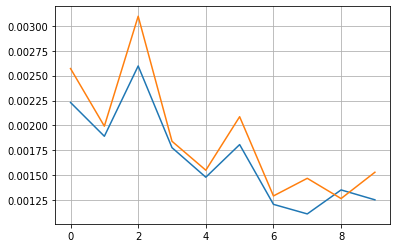

Wall time: 59 s


In [62]:
%%time
# to find the what happenswhen we switch dropout

train_net_and_plot(design_net(0.2, 0.6))

for epoch 0 train loss : 0.002444753423333168 test loss : 0.002566843293607235
for epoch 1 train loss : 0.0020855064503848553 test loss : 0.0022271964699029922
for epoch 2 train loss : 0.0018440164858475327 test loss : 0.0016489468980580568
for epoch 3 train loss : 0.001592948567122221 test loss : 0.0016982093220576644
for epoch 4 train loss : 0.0015062125166878104 test loss : 0.0016245772130787373
for epoch 5 train loss : 0.002155256923288107 test loss : 0.0023468409199267626
for epoch 6 train loss : 0.0014559461269527674 test loss : 0.001458277809433639
for epoch 7 train loss : 0.000978641677647829 test loss : 0.0015951312379911542
for epoch 8 train loss : 0.0018289658473804593 test loss : 0.0020068855956196785
for epoch 9 train loss : 0.0013683451106771827 test loss : 0.001035240013152361


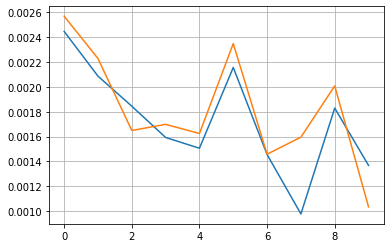

Wall time: 56.7 s


In [63]:
%%time
train_net_and_plot(design_net(0.6, 0.2))

for epoch 0 train loss : 0.003451281925663352 test loss : 0.003367380006238818
for epoch 1 train loss : 0.002010430907830596 test loss : 0.0026790255215018988
for epoch 2 train loss : 0.0016175906639546156 test loss : 0.0016179399099200964
for epoch 3 train loss : 0.0013856174191460013 test loss : 0.001609757891856134
for epoch 4 train loss : 0.0012479177676141262 test loss : 0.0015562139451503754
for epoch 5 train loss : 0.002921877196058631 test loss : 0.00334707903675735
for epoch 6 train loss : 0.0013339979341253638 test loss : 0.0016245247097685933
for epoch 7 train loss : 0.0010561817325651646 test loss : 0.0018188613466918468
for epoch 8 train loss : 0.0013554813340306282 test loss : 0.0014274497516453266
for epoch 9 train loss : 0.0013958860654383898 test loss : 0.0015154872089624405


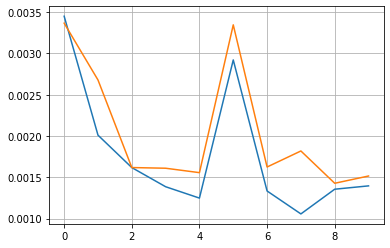

Wall time: 55 s


In [61]:
%%time
#2 

# trying to find the dropout use

train_net_and_plot(design_net(0, 0))

Weight decay 0.3 used.
for epoch 0 train loss : 0.008997439406812191 test loss : 0.008999170735478401
for epoch 1 train loss : 0.00899246521294117 test loss : 0.00900084525346756
for epoch 2 train loss : 0.008995262905955315 test loss : 0.008998516947031021
for epoch 3 train loss : 0.008991009555757046 test loss : 0.008995971642434597
for epoch 4 train loss : 0.008997404016554356 test loss : 0.00899811927229166
for epoch 5 train loss : 0.009002973325550556 test loss : 0.008990694768726826
for epoch 6 train loss : 0.008995160460472107 test loss : 0.009000996127724648
for epoch 7 train loss : 0.008989418856799603 test loss : 0.008997762575745583
for epoch 8 train loss : 0.008998027071356773 test loss : 0.008992156013846397
for epoch 9 train loss : 0.008995717391371727 test loss : 0.008985260501503944


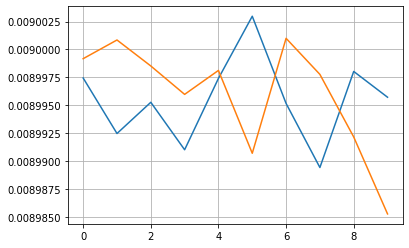

Wall time: 2min 27s


In [64]:
%%time
# 4

# not used at runtime because we want that dropout not to take out features that are important


# 5

# using weight decay and dropout

train_net_and_plot(design_net(0.2, 0.6), wd=0.3)

Weight decay 0.3 used.
for epoch 0 train loss : 0.00898654293268919 test loss : 0.008996810764074326
for epoch 1 train loss : 0.008999037556350231 test loss : 0.008999399840831757
for epoch 2 train loss : 0.008993295021355152 test loss : 0.008984081447124481
for epoch 3 train loss : 0.008988463319838047 test loss : 0.008996779099106789
for epoch 4 train loss : 0.008990452624857426 test loss : 0.008989742957055569
for epoch 5 train loss : 0.00899283867329359 test loss : 0.008988957852125168
for epoch 6 train loss : 0.00900091603398323 test loss : 0.009003608487546444
for epoch 7 train loss : 0.008995677344501019 test loss : 0.008994776755571365
for epoch 8 train loss : 0.008986111730337143 test loss : 0.008987240493297577
for epoch 9 train loss : 0.008996422402560711 test loss : 0.009000659920275211


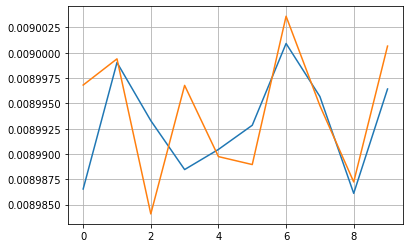

Wall time: 2min 31s


In [65]:
# %%time
# # just using wd

# train_net_and_plot(design_net(0,0), wd=0.3)

# just using dropout works better than using together with weight decay

In [70]:
# 6

class Net_exp(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, dropout1, dropout2, dropout_to_weight=False, print_variance=False):
        super(Net_exp, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.print_variance = print_variance
        self.dropout_to_weight = dropout_to_weight
        self.relu = nn.ReLU()
        self.variance_array1 = []
        self.variance_array2 = []
    
    def forward(self, X):
        if(self.dropout_to_weight==False):

            out = self.relu(self.lin1(X))
            if(self.print_variance):
                self.variance_array1.append(torch.var(out.detach()))

            out = dropout_layer(out, self.dropout1)
            out = self.relu(self.lin2(out))
            
            if(self.print_variance):
                self.variance_array2.append(torch.var(out.detach()))

            out = dropout_layer(out, self.dropout2)
            out = self.lin3(out)

            return out
        else:
            # apllying dropout to weight
            out = self.lin1(X)
            out = dropout_layer(out, self.dropout1)
            out = self.relu(out)
            out = self.lin2(out)
            out = dropout_layer(out, self.dropout2)
            out = self.relu(out)
            out = self.lin3(out)

            return out
        
    def give_moolah(self):
        return self.variance_array1, self.variance_array2

In [71]:
# 3

# printing variance
# with dropout
net_exp = Net_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0.2,0.5,print_variance=True)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_exp.apply(init_parma)

Net_exp(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

In [72]:
X1 = torch.normal(0, 0.1, (1, 784))

net_exp(X1)

tensor([[-0.0642, -0.0409,  0.0541, -0.0106, -0.0237,  0.0491,  0.0125, -0.0510,
         -0.0551, -0.0609]], grad_fn=<AddmmBackward>)

In [73]:
# printing variance
# without dropout
net_exp = Net_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0,0,print_variance=True)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_exp.apply(init_parma)

net_exp(X1)

tensor([[ 0.0184, -0.0421,  0.0097,  0.0351,  0.0462,  0.0101, -0.0428, -0.0210,
          0.0326,  0.0251]], grad_fn=<AddmmBackward>)

In [74]:
net_exp.give_moolah()

([tensor(0.0004)], [tensor(0.0004)])

In [76]:
len(train_dataloader)

235

In [80]:
optimizer = torch.optim.SGD(net_exp.parameters(), lr=0.5)
loss = nn.CrossEntropyLoss()


for epoch in range(5):
    for X,y in train_dataloader:
        l = loss(net_exp(X.reshape(-1,784)), y)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        



In [83]:
h1_array, h2_array = net_exp.give_moolah()

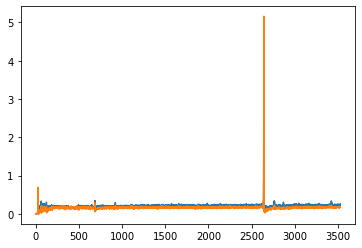

In [85]:
plt.plot(range(3526), h1_array)
plt.plot(range(3526), h2_array)

In [95]:
class Next_exp(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, dropout1, dropout2):
        super(Next_exp, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.lin1(X.reshape(-1,784))
        out = dropout_layer(out, self.dropout1)
        out = self.relu(out)
        out = self.lin2(out)
        out = dropout_layer(out, self.dropout2)
        out = self.relu(out)
        out = self.lin3(out)

        return out
        
   

In [96]:
# adding dropout to weight

next_exp = Next_exp(num_inputs, num_outputs, num_hidden1, num_hidden2,0.2,0.5)

def init_parma(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

next_exp.apply(init_parma)

next_exp(X1)

tensor([[ 0.0366,  0.0230, -0.0030, -0.0607,  0.0464,  0.0596, -0.0125,  0.0422,
         -0.0359, -0.0501]], grad_fn=<AddmmBackward>)

In [98]:
next_exp

Next_exp(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

for epoch 0 train loss : 0.0030567876528948545 test loss : 0.003201053710654378
for epoch 1 train loss : 0.0024650327395647764 test loss : 0.0024126246571540833
for epoch 2 train loss : 0.0017950204201042652 test loss : 0.001987556926906109
for epoch 3 train loss : 0.002071228576824069 test loss : 0.0022386345081031322
for epoch 4 train loss : 0.0015209752600640059 test loss : 0.0015904104802757502
for epoch 5 train loss : 0.0020143527071923018 test loss : 0.0018796472577378154
for epoch 6 train loss : 0.0013042655773460865 test loss : 0.0016173472395166755
for epoch 7 train loss : 0.002040001330897212 test loss : 0.00247761863283813
for epoch 8 train loss : 0.0012014632811769843 test loss : 0.0015508021460846066
for epoch 9 train loss : 0.0017943966668099165 test loss : 0.0013788094511255622


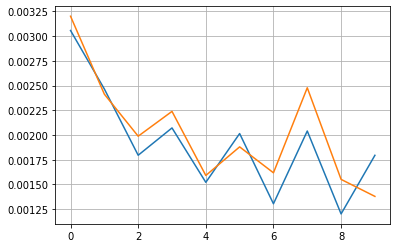

In [99]:
train_net_and_plot(next_exp)

In [105]:
#7 Another technique forinjecting randomnoise

# we can put an epsilon value into the neuralnetwork


class net_epsilon(nn.Module):
    def __init__(self, num_inputs=784, num_outputs=10, num_hidden1=256, num_hidden2=256, epsilon_m=0.02, epsilon_d=0.02):
        super(net_epsilon, self).__init__()
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
        self.epsilon_m = epsilon_m
        self.epsilon_d = epsilon_d
        self.num_inputs = num_inputs
    
    def forward(self, X):
        out = self.relu(self.lin1(X.reshape(-1,self.num_inputs)))
#         print(out.shape)
        out = out + torch.normal(self.epsilon_m, self.epsilon_d, (out.shape))
        out = self.relu(self.lin2(out))
        out = out + torch.normal(self.epsilon_m, self.epsilon_d, (out.shape))
        out = self.lin3(out)
        return out

In [107]:
net = net_epsilon()
net(X1).detach()

tensor([[ 0.0088, -0.0644,  0.0253, -0.0070,  0.0046,  0.0744,  0.0613, -0.0535,
         -0.0049,  0.0434]])

for epoch 0 train loss : 0.0021624471992254257 test loss : 0.002369646215811372
for epoch 1 train loss : 0.0024072309024631977 test loss : 0.002642210805788636
for epoch 2 train loss : 0.0018805674044415355 test loss : 0.002086358843371272
for epoch 3 train loss : 0.0015025839675217867 test loss : 0.0012006770120933652
for epoch 4 train loss : 0.0020782870706170797 test loss : 0.0022974859457463026
for epoch 5 train loss : 0.0013138307258486748 test loss : 0.0014544193400070071
for epoch 6 train loss : 0.0012734906049445271 test loss : 0.001918449648655951
for epoch 7 train loss : 0.0012636042665690184 test loss : 0.0017541254637762904
for epoch 8 train loss : 0.0013598039513453841 test loss : 0.0011599172139540315
for epoch 9 train loss : 0.0019687593448907137 test loss : 0.0023817287292331457


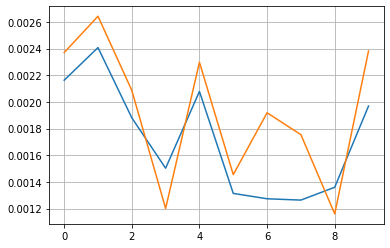

In [108]:
train_net_and_plot(net)